In [ ]:
import os
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import (
    EventAccumulator,
)


def load_tensorboard_run(run_dir):
    event_acc = EventAccumulator(run_dir)
    event_acc.Reload()

    tags = event_acc.Tags()
    run_data = {}

    # --- Scalars ---
    if "scalars" in tags:
        for tag in tags["scalars"]:
            scalars = event_acc.Scalars(tag)
            print(f"SCALARS:: {scalars[:3]} ... | {tag}")
            run_data[tag] = [s.value for s in scalars]
            run_data["step"] = [s.step for s in scalars]

    # --- Histograms ---
    hist_data = {}
    if "histograms" in tags:
        for tag in tags["histograms"]:
            hists = event_acc.Histograms(tag)
            print(f"HISTOGRAM:: {len(hists)} entries for {tag}")
            hist_data[tag] = hists

    # --- Distributions ---
    dist_data = {}
    if "distributions" in tags:
        for tag in tags["distributions"]:
            dists = event_acc.CompressedHistograms(tag)
            print(f"DISTRIBUTION:: {len(dists)} entries for {tag}")
            dist_data[tag] = dists

    return pd.DataFrame(run_data), hist_data, dist_data

In [ ]:
def list_tags(run_dir):
    event_acc = EventAccumulator(run_dir)
    event_acc.Reload()
    return event_acc.Tags() 

In [4]:
# Path where all runs are stored
base_path = "../runs/"
# tags = ["step", "epoch", "score", "q_values", "mean_q_value"]

for runs in os.listdir(base_path):
    base_run_path = os.path.join(base_path, runs)
    for run_dir in os.listdir(base_run_path):
        run_path = os.path.join(base_run_path, run_dir)
        if os.path.isdir(run_path):
            try:
                tags = list_tags(run_path)
                # print("Available tags:", tags, "\n")
            except Exception as e:
                print(f"Skipping {run_path}: {e}")
tags

{'images': [],
 'audio': [],
 'histograms': [],
 'scalars': ['score', 'total_steps'],
 'distributions': [],
 'tensors': [],
 'graph': False,
 'meta_graph': False,
 'run_metadata': []}

In [ ]:
all_runs = []
all_hists = {}
all_dists = {}

for runs in os.listdir(base_path):
    base_run_path = os.path.join(base_path, runs)
    for run_dir in os.listdir(base_run_path):
        run_path = os.path.join(base_run_path, run_dir)
        if os.path.isdir(run_path):
            try:
                df, hist_data, dist_data = load_tensorboard_run(run_path)

                df["run_name"] = run_path
                all_runs.append(df)

                all_hists[run_path] = hist_data
                all_dists[run_path] = dist_data

            except Exception as e:
                print(f"Skipping {run_path}: {e}")

SCALARS:: [ScalarEvent(wall_time=1755590945.6302779, step=1, value=104.70610809326172), ScalarEvent(wall_time=1755590945.8784819, step=1, value=20.939592361450195), ScalarEvent(wall_time=1755590946.0091038, step=1, value=22.070270538330078)] ... | score
SCALARS:: [ScalarEvent(wall_time=1755590945.6302972, step=1, value=3.0), ScalarEvent(wall_time=1755590945.8785028, step=1, value=6.0), ScalarEvent(wall_time=1755590946.0091221, step=1, value=8.0)] ... | total_steps
SCALARS:: [ScalarEvent(wall_time=1755590945.631047, step=1, value=0.2799900770187378), ScalarEvent(wall_time=1755590945.879647, step=1, value=0.5675663948059082), ScalarEvent(wall_time=1755590946.009782, step=1, value=0.736754298210144)] ... | mean_q_value
HISTOGRAM:: 1 entries for q_values
DISTRIBUTION:: 500 entries for q_values
SCALARS:: [ScalarEvent(wall_time=1755594054.901023, step=1, value=5.4784836769104), ScalarEvent(wall_time=1755594055.078549, step=1, value=6.122608661651611), ScalarEvent(wall_time=1755594055.196383,

In [6]:
if all_runs:
    results = pd.concat(all_runs, ignore_index=True)
else:
    print("No runs found")
results.head()

,score,step,total_steps,mean_q_value,run_name
0,104.706108,1,3.0,0.279990,../runs/20250819_103635/CQL_frac0.50_epochs10
1,20.939592,1,6.0,0.567566,../runs/20250819_103635/CQL_frac0.50_epochs10
2,22.070271,1,8.0,0.736754,../runs/20250819_103635/CQL_frac0.50_epochs10
3,17.445807,1,9.0,0.815507,../runs/20250819_103635/CQL_frac0.50_epochs10
4,13.584818,1,11.0,1.011901,../runs/20250819_103635/CQL_frac0.50_epochs10


In [7]:
results.shape

(80000, 5)

In [8]:
for run_name, run_df in results.groupby("run_name"):
    scores = run_df["score"]
    
    min_score = scores.min()
    max_score = scores.max()
    mean_score = scores.mean()
    
    # rows corresponding to min and max scores
    min_row = run_df.loc[scores.idxmin()]
    max_row = run_df.loc[scores.idxmax()]
    
    print(f"Run: {run_name}")
    print(f"  Score - min: {min_score}, step: {min_row['step']}, total_steps: {min_row['total_steps']}")
    print(f"  Score - max: {max_score}, step: {max_row['step']}, total_steps: {max_row['total_steps']}")
    print(f"  Score - mean: {mean_score:.4f}")
    print("-" * 60)

Run: ../runs/20250819_103635/BC_frac0.25_epochs10
  Score - min: 24.563493728637695, step: 1, total_steps: 6.0
  Score - max: 360.71893310546875, step: 8, total_steps: 15908.0
  Score - mean: 267.0091
------------------------------------------------------------
Run: ../runs/20250819_103635/BC_frac0.50_epochs10
  Score - min: 104.1415023803711, step: 1, total_steps: 3.0
  Score - max: 314.79150390625, step: 7, total_steps: 12306.0
  Score - mean: 274.6330
------------------------------------------------------------
Run: ../runs/20250819_103635/CQL_awac_frac0.25_epochs10
  Score - min: -0.7935969829559326, step: 1, total_steps: 3.0
  Score - max: 423.85003662109375, step: 6, total_steps: 10566.0
  Score - mean: 271.6748
------------------------------------------------------------
Run: ../runs/20250819_103635/CQL_awac_frac0.50_epochs10
  Score - min: 1.569722294807434, step: 1, total_steps: 16.0
  Score - max: 454.69287109375, step: 8, total_steps: 14174.0
  Score - mean: 274.3467
-------

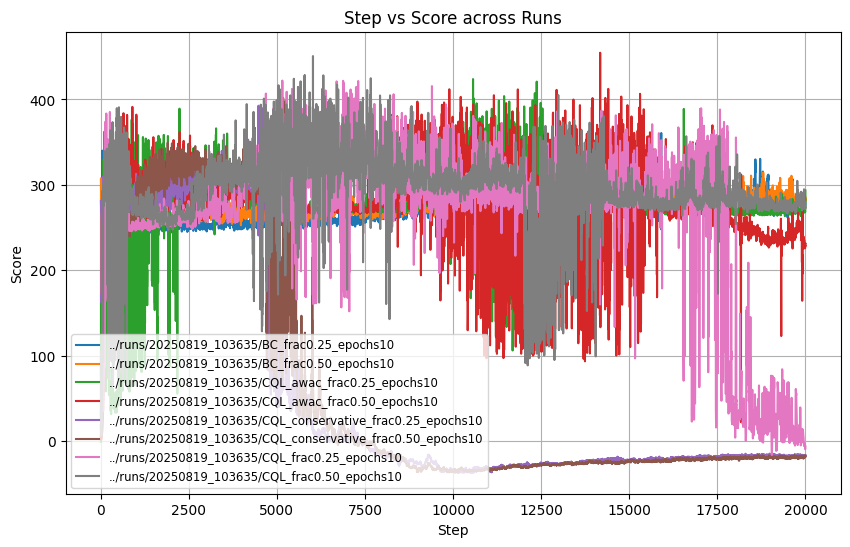

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for run_name, run_df in results.groupby("run_name"):
    plt.plot(run_df["total_steps"], run_df["score"], label=run_name)

plt.xlabel("Step")
plt.ylabel("Score")
plt.title("Step vs Score across Runs")
plt.legend(loc="best", fontsize="small")
plt.grid(True)
plt.show()


Number of runs: 8


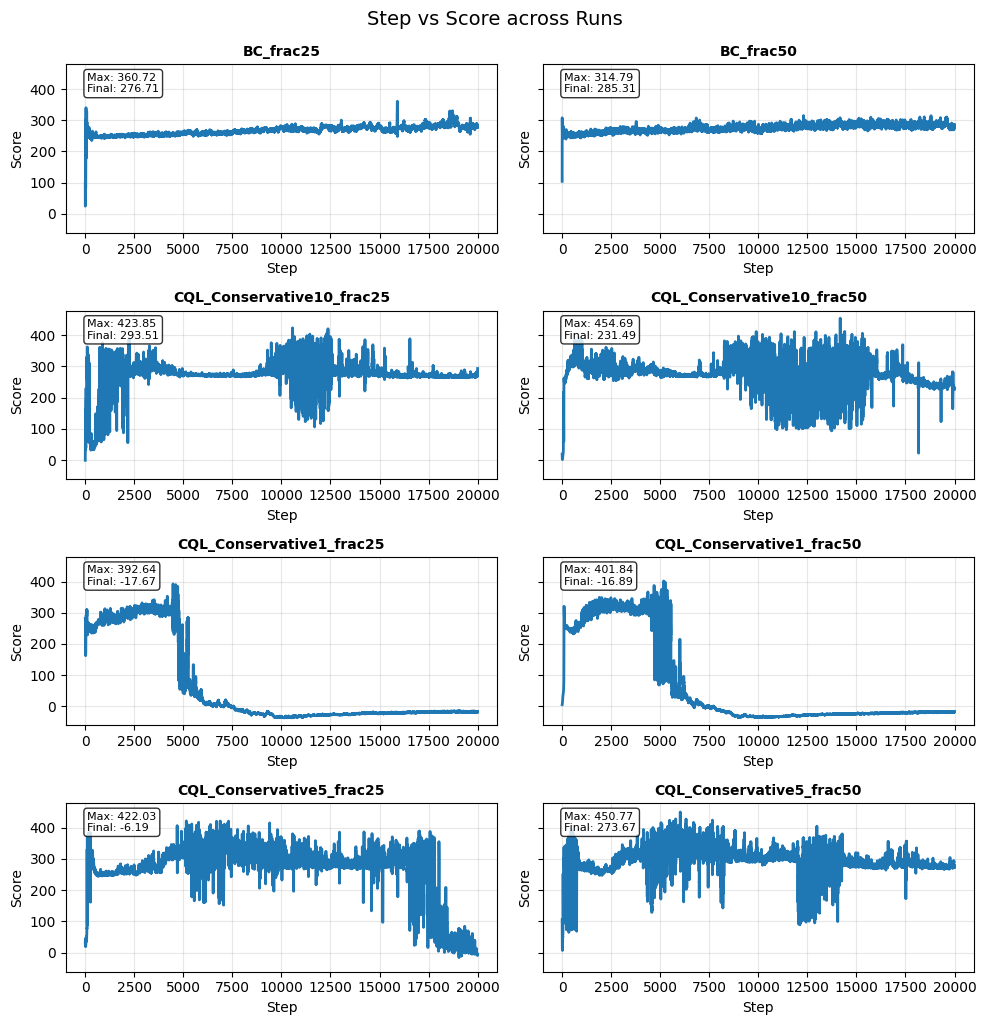

In [ ]:
from pdb import run
import matplotlib.pyplot as plt
import numpy as np

run_names = results["run_name"].unique()
n_runs = len(run_names)

print(f"Number of runs: {n_runs}")

if n_runs <= 4:
    rows, cols = 1, n_runs
elif n_runs <= 8:
    rows, cols = 4, 2
elif n_runs <= 12:
    rows, cols = 3, 4
else:
    rows = int(np.ceil(np.sqrt(n_runs)))
    cols = int(np.ceil(n_runs / rows))

fig, axes = plt.subplots(rows, cols, figsize=(10, 10), sharey=True)


if rows == 1:
    axes = axes.reshape(1, -1) if n_runs > 1 else np.array([[axes]])
elif cols == 1:
    axes = axes.reshape(-1, 1)


for idx, (run_name, run_df) in enumerate(results.groupby("run_name")):
    row = idx // cols
    col = idx % cols
    ax = axes[row, col]
    run_name = run_name.split("/")[-1].replace("_epochs10", "").replace("0.", "")
    if "CQL" in run_name:
        if "awac" in run_name:
            run_name = run_name.replace("awac", "Conservative10")
        elif "conservative" in run_name:
            run_name = run_name.replace("conservative", "Conservative1")
        else:
            run_name = run_name.replace("CQL_", "CQL_Conservative5_")
    
    ax.plot(run_df["total_steps"], run_df["score"], linewidth=2, color='#1f77b4')
    ax.set_title(run_name, fontsize=10, fontweight='bold')
    ax.set_xlabel("Step")
    ax.set_ylabel("Score")
    ax.grid(True, alpha=0.3)
    

    max_score = run_df["score"].max()
    final_score = run_df["score"].iloc[-1]
    ax.text(0.05, 0.95, f'Max: {max_score:.2f}\nFinal: {final_score:.2f}', 
            transform=ax.transAxes, verticalalignment='top', 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
            fontsize=8)

for idx in range(n_runs, rows * cols):
    row = idx // cols
    col = idx % cols
    axes[row, col].set_visible(False)

plt.tight_layout()
plt.suptitle("Step vs Score across Runs", fontsize=14, y=1.02)
plt.show()


1. BC_frac0.25_epochs10 – Gradual improvement, stabilizes around 276 final score.
2. BC_frac0.50_epochs10 – Similar stable learning, final ~285 score.
3. CQL_conservative_10_frac0.25_epochs10 – Unstable but maintains ~293 final score.
4. CQL_conservative_10_frac0.50_epochs10 – High variance, ends lower at ~231 final score.
5. CQL_conservative_1_frac0.25_epochs10 – Collapses after early learning, final negative score.
6. CQL_conservative_1_frac0.50_epochs10 – Same collapse pattern, final negative score.
7. CQL_conservative_5_frac0.25_epochs10 – Early stability then severe drop, final negative score.
8. CQL_conservative_5_frac0.50_epochs10 – Noisy but sustains learning, ends strong at ~274 final score.

Step 10: limits shape (687,), counts shape (687,)
Trimmed counts to shape (686,)


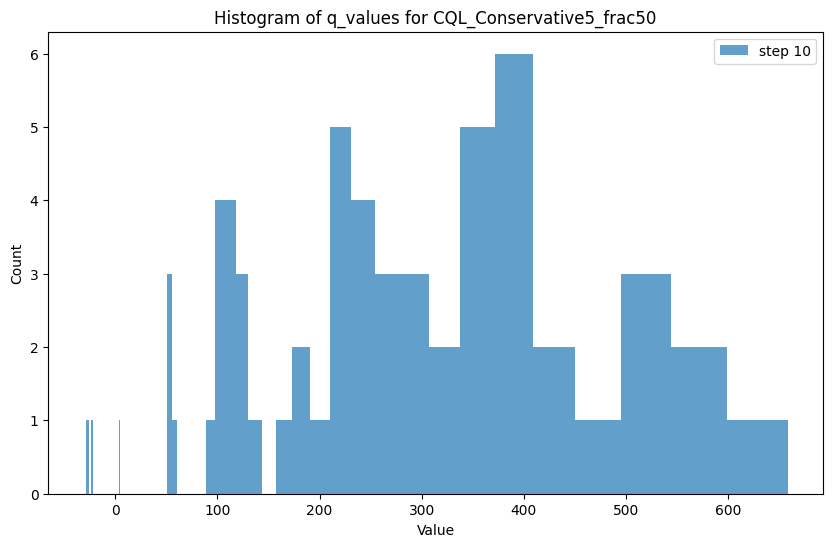

Step 10: limits shape (679,), counts shape (679,)
Trimmed counts to shape (678,)


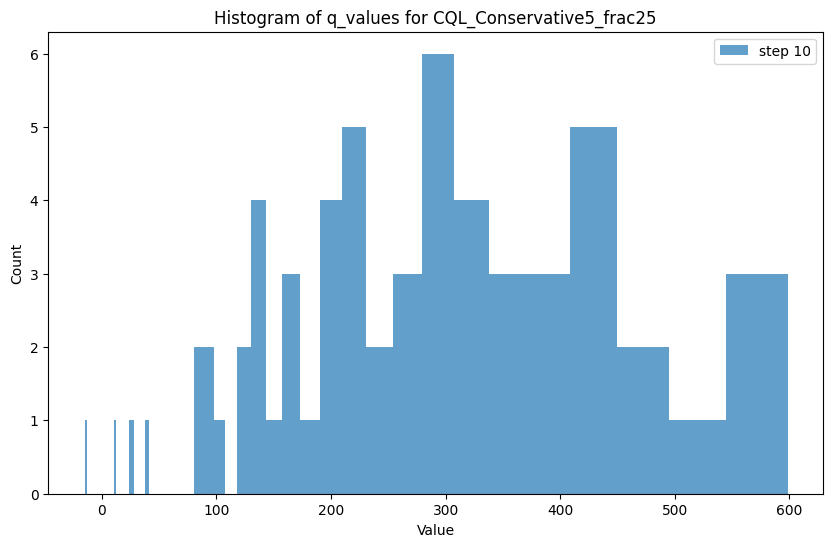

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

for run_name, hists in all_hists.items():
    if not hists:
        continue
    plt.figure(figsize=(10, 6))
    
    for i, hist in enumerate(hists["q_values"][:5]): 
        step = hist.step
        limits = np.array(hist.histogram_value.bucket_limit) 
        counts = np.array(hist.histogram_value.bucket)  
        
        print(f"Step {step}: limits shape {limits.shape}, counts shape {counts.shape}")
        
        # Handle shape mismatch
        if len(counts) == len(limits):
            # If counts has same length as limits, assume last bin is overflow
            # and trim it to match expected N bins for N+1 limits
            counts = counts[:-1]
            print(f"Trimmed counts to shape {counts.shape}")
        elif len(counts) != len(limits) - 1:
            print(f"Warning: Unexpected shape mismatch. Skipping step {step}")
            continue
        
        centers = (limits[:-1] + limits[1:]) / 2   
        widths = limits[1:] - limits[:-1]      
        
        # Verify shapes match before plotting
        assert len(centers) == len(counts) == len(widths), f"Shape mismatch: centers {len(centers)}, counts {len(counts)}, widths {len(widths)}"
        
        plt.bar(centers, counts, width=widths, 
                alpha=0.7, label=f"step {step}" if i < 3 else "")
        run_name = run_name.split("/")[-1].replace("_epochs10", "").replace("0.", "")
        if "CQL" in run_name:
            if "awac" in run_name:
                run_name = run_name.replace("awac", "Conservative10")
            elif "conservative" in run_name:
                run_name = run_name.replace("conservative", "Conservative1")
            else:
                run_name = run_name.replace("CQL_", "CQL_Conservative5_")
    plt.title(f"Histogram of q_values for {run_name}")
    plt.xlabel("Value") 
    plt.ylabel("Count")
    plt.legend()
    plt.show()

Run: ../runs/20250819_103635/CQL_frac0.50_epochs10
Number of steps: 500
First percentiles shape/type: <class 'list'>, (9, 2)
First percentiles content: [(0, np.float64(1.4700721502304077)), (668, np.float64(1.9722112954596571)), (1587, np.float64(2.1007045910200715)), (3085, np.float64(2.2291192386166636)), (5000, np.float64(2.3496079191924935)), (6915, np.float64(2.5259072921756927)), (8413, np.float64(2.7606923770534806)), (9332, np.float64(3.074809963773699)), (10000, 3.6428747177124023)]
Number of percentiles: 18
Final shapes - steps: (500,), p10: (500,), medians: (500,), p90: (500,)


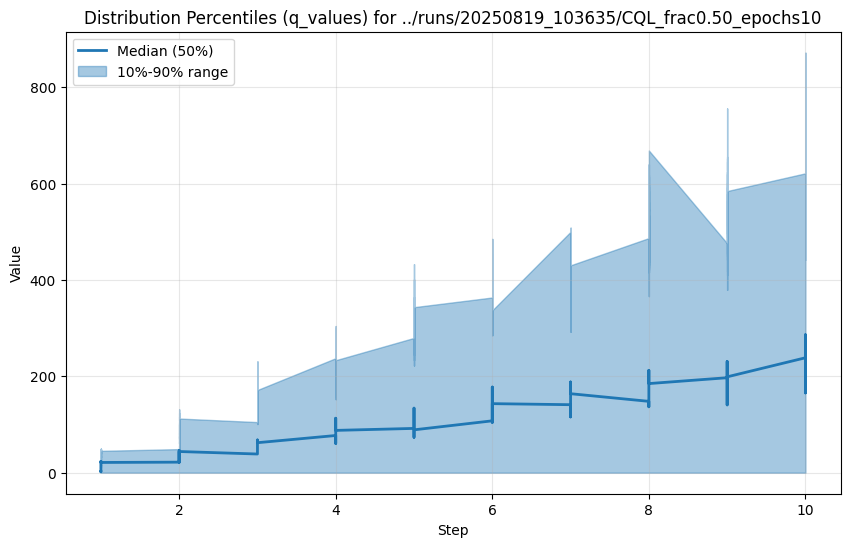

Run: ../runs/20250819_103635/CQL_frac0.25_epochs10
Number of steps: 500
First percentiles shape/type: <class 'list'>, (9, 2)
First percentiles content: [(0, np.float64(1.5347318649291992)), (668, np.float64(1.7173855372842501)), (1587, np.float64(1.9685706341599836)), (3085, np.float64(2.1135732800749003)), (5000, np.float64(2.325030430498011)), (6915, np.float64(2.5167318930163285)), (8413, np.float64(2.7233065056793597)), (9332, np.float64(3.0028421613785166)), (10000, 3.3712635040283203)]
Number of percentiles: 18
Final shapes - steps: (500,), p10: (500,), medians: (500,), p90: (500,)


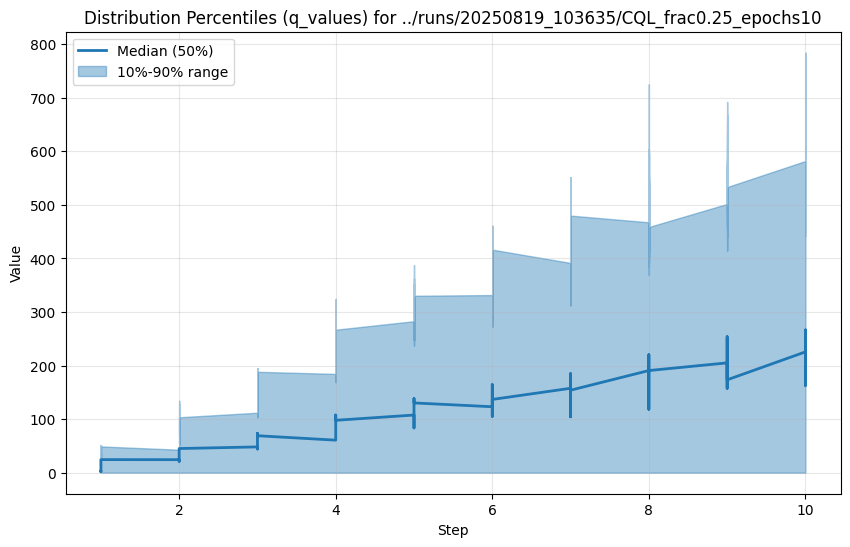

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

for run_name, dists in all_dists.items():
    if not dists:
        continue
    
    steps = [d.step for d in dists["q_values"]]
    percentiles = [d.compressed_histogram_values for d in dists["q_values"]]
    
    print(f"Run: {run_name}")
    print(f"Number of steps: {len(steps)}")
    print(f"First percentiles shape/type: {type(percentiles[0])}, {np.array(percentiles[0]).shape if percentiles else 'N/A'}")
    if percentiles:
        print(f"First percentiles content: {percentiles[0]}")
    

    try:

        flattened_percentiles = []
        for p in percentiles:
            if hasattr(p, '__len__') and len(p) > 0:

                p_array = np.array(p)
                if p_array.ndim > 1:
                    p_flat = p_array.flatten()
                else:
                    p_flat = p_array
                flattened_percentiles.append(p_flat)
            else:
                flattened_percentiles.append([])
        
        if not flattened_percentiles or len(flattened_percentiles[0]) == 0:
            print(f"No valid percentile data for {run_name}")
            continue
            
        # Determine percentile indices (common formats: [10,25,50,75,90] or [0,25,50,75,100])
        n_percentiles = len(flattened_percentiles[0])
        print(f"Number of percentiles: {n_percentiles}")
        
        if n_percentiles >= 3:

            if n_percentiles == 5:  # [10, 25, 50, 75, 90] format
                p10 = [p[0] for p in flattened_percentiles]
                medians = [p[2] for p in flattened_percentiles]
                p90 = [p[4] for p in flattened_percentiles]
            elif n_percentiles >= 5: 
                p10 = [p[0] for p in flattened_percentiles]  
                medians = [p[n_percentiles//2] for p in flattened_percentiles]
                p90 = [p[-1] for p in flattened_percentiles] 
            else:
                p10 = [p[0] for p in flattened_percentiles]
                medians = [p[1] if len(p) > 1 else p[0] for p in flattened_percentiles]
                p90 = [p[-1] for p in flattened_percentiles]
            
            steps_array = np.array(steps)
            p10_array = np.array(p10).flatten()
            medians_array = np.array(medians).flatten()
            p90_array = np.array(p90).flatten()
            
            print(f"Final shapes - steps: {steps_array.shape}, p10: {p10_array.shape}, medians: {medians_array.shape}, p90: {p90_array.shape}")
            
            # Plot
            plt.figure(figsize=(10, 6))
            plt.plot(steps_array, medians_array, linewidth=2, label="Median (50%)", color='#1f77b4')
            
            plt.fill_between(steps_array, p10_array, p90_array, 
                           alpha=0.4, label="10%-90% range", color='#1f77b4')
            
            plt.title(f"Distribution Percentiles (q_values) for {run_name}")
            plt.xlabel("Step")
            plt.ylabel("Value")
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
            
        else:
            print(f"Insufficient percentile data for {run_name} (only {n_percentiles} percentiles)")
            
    except Exception as e:
        print(f"Error processing {run_name}: {e}")
        print(f"Percentiles structure: {[type(p) for p in percentiles[:3]]}")  # Show first 3 types
        continue